In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
# import opendatasets as od
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
Project_Name='Indian-Sign-Language'

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# Look into the data directory
# Change the directory as required
Data_Directory = '/content/gdrive/MyDrive/SignLanguage - Copy/data/'
Classes_In_Dataset = os.listdir(Data_Directory)
print(Classes_In_Dataset)

['X', 'U', 'Y', 'R', 'T', 'Q', 'V', 'W', 'Z', 'S', 'O', 'K', 'P', 'M', 'H', 'G', 'L', 'I', 'J', 'N', 'B', '9', 'E', 'C', 'D', '7', 'F', '6', '8', 'A', '2', '4', '1', '5', '3']


In [ ]:
# Let's evaluate a single class say "A"
A_File_In_Dataset = os.listdir(Data_Directory+"A")
print("NO. of Training examples for Man:",len(A_File_In_Dataset))
print(A_File_In_Dataset[:5])

NO. of Training examples for Man: 150
['100.jpg', '1.jpg', '10.jpg', '0.jpg', '101.jpg']


In [ ]:
# Let's evaluate a single class say "A"
Num_9_File_In_Dataset = os.listdir(Data_Directory+"A")
print("NO. of Training examples for Man:",len(Num_9_File_In_Dataset))
print(Num_9_File_In_Dataset[:5])

NO. of Training examples for Man: 150
['100.jpg', '1.jpg', '10.jpg', '0.jpg', '101.jpg']


In [ ]:
Data_Dictonary={}
for i in Classes_In_Dataset:
    Data_Dictonary[i]=len(os.listdir(Data_Directory+i))
print(Data_Dictonary)

{'X': 150, 'U': 150, 'Y': 150, 'R': 150, 'T': 150, 'Q': 150, 'V': 150, 'W': 150, 'Z': 150, 'S': 150, 'O': 150, 'K': 150, 'P': 150, 'M': 150, 'H': 150, 'G': 150, 'L': 150, 'I': 150, 'J': 150, 'N': 150, 'B': 150, '9': 150, 'E': 150, 'C': 150, 'D': 150, '7': 150, 'F': 150, '6': 150, '8': 150, 'A': 150, '2': 150, '4': 150, '1': 150, '5': 150, '3': 150}


In [ ]:
Traget_Numbers = len(Classes_In_Dataset)
Traget_Numbers

35

In [ ]:
# THe below function will print a batch of 64 images from the dataset
def show_batch(Datasets):
    for Images, Labels in Datasets:
        Figure, Axis = plt.subplots(figsize=(12, 12))
        Axis.set_xticks([]); Axis.set_yticks([])
        Axis.imshow(make_grid(Images[:64], nrow=8).permute(1, 2, 0))
        break

In [ ]:
Raw_Images_In_Datasets = ImageFolder(Data_Directory, tt.ToTensor())

Dimension: torch.Size([3, 128, 128])


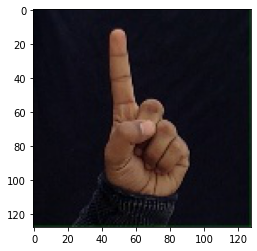

In [ ]:
Images, Label = Raw_Images_In_Datasets[0]
print("Dimension:", Images.shape)
plt.imshow(Images.permute(1, 2, 0))

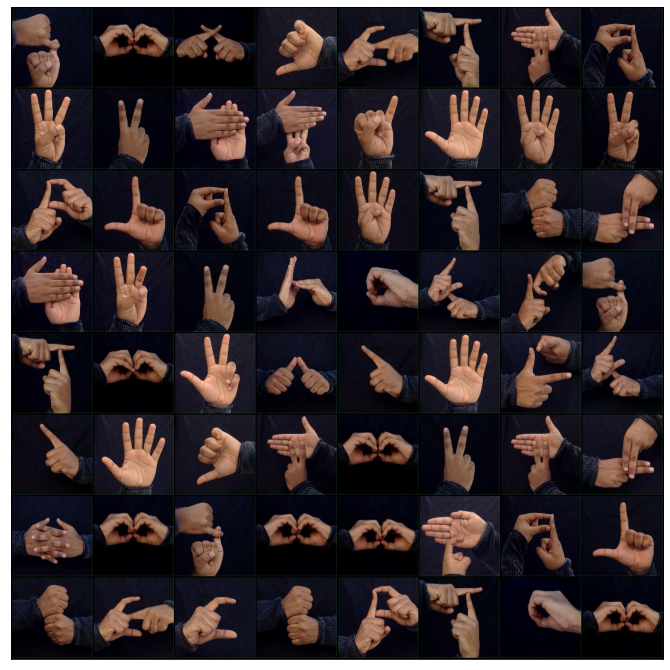

In [ ]:
# Let's create a dataloader for raw images
Raw_data_Found = DataLoader(Raw_Images_In_Datasets, 400, shuffle=True, num_workers=2, pin_memory=True)
show_batch(Raw_data_Found)

In [ ]:
Average_of_Data  = torch.Tensor([0,0,0])
Standard_Dev_of_Data = torch.Tensor([0,0,0])

for Image, Labels in Raw_Images_In_Datasets:
    Average_of_Data += Image.mean([1,2])
    Standard_Dev_of_Data += Image.std([1,2])
stats_avgs = (Average_of_Data / len(Raw_Images_In_Datasets)).tolist()
stats_stds =  (Standard_Dev_of_Data / len(Raw_Images_In_Datasets)).tolist()
stats_avgs, stats_stds

([0.1826605349779129, 0.13925956189632416, 0.15048161149024963],
 [0.2287309765815735, 0.1608881801366806, 0.11466306447982788])

In [ ]:
# Data transforms (normalization & data augmentation)

stats = (stats_avgs, stats_stds)
train_tfms = tt.Compose([# tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [ ]:
train_data = ImageFolder(data_dir, transform=train_tfms)
valid_data = ImageFolder(data_dir, transform=valid_tfms)
test_data = ImageFolder(data_dir, transform=valid_tfms)

In [ ]:
num_train = len(train_data)
indices = list(range(num_train))
# We'll fix the random state to avoid change in the creation of train and valid data.
np.random.seed(42)
np.random.shuffle(indices)
# Let's take 15% of the train data as validation and 10% as test
valid_size = 0.15
test_size = 0.10
val_split = int(np.floor(valid_size * num_train))
test_split = int(np.floor(test_size * num_train))
valid_idx, test_idx, train_idx = indices[:val_split], indices[val_split:val_split+test_split], indices[val_split+test_split:]

In [ ]:
batch_size = 250

In [ ]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
# test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders
train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=2, pin_memory=True)
valid_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=2, pin_memory=True)
# test_dl = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
#     sampler=test_sampler, num_workers=2, pin_memory=True)

In [ ]:
# Let's remove the unwanted variables from memory
del raw_images, average, standard_dev, raw_dl

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl, denorm=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        if denorm:
            images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

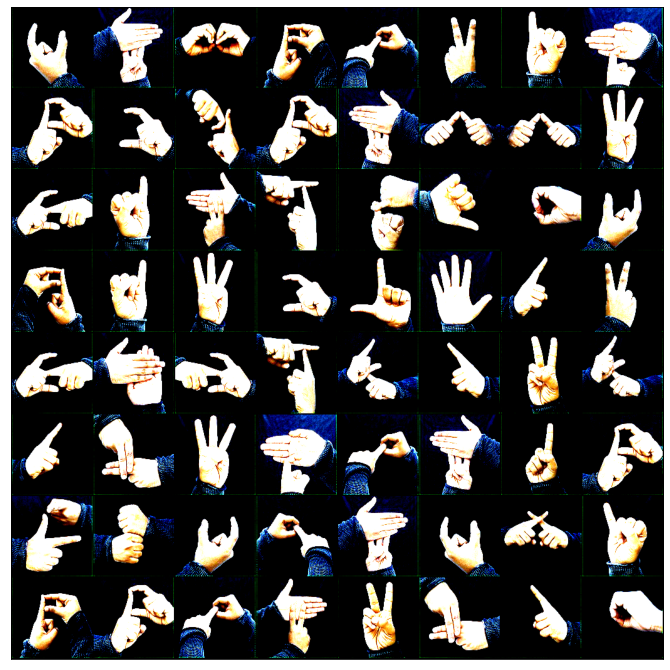

In [ ]:
# Normalized and Augmented Image
show_batch(train_dl)

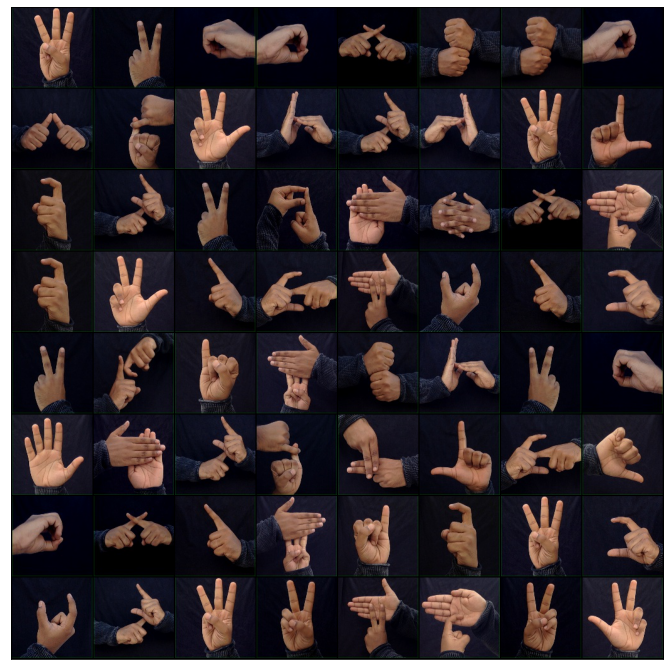

In [ ]:
# Original Image
show_batch(train_dl, denorm=True)

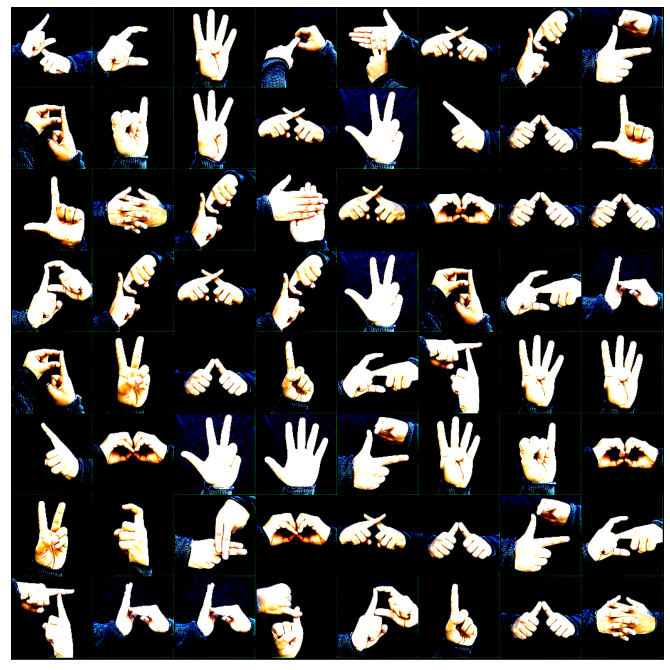

In [ ]:
show_batch(valid_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64, pool=True) # 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) # 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) # 512 x 8 x 8
        self.conv5 = conv_block(512, 512, pool=True) # 512 x 4 x 4

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, target_num), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.554824113845825, 'val_acc': 0.02499999850988388}]

In [ ]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00373, train_loss: 1.0436, val_loss: 3.5878, val_acc: 0.2756
Epoch [1], last_lr: 0.00932, train_loss: 0.0101, val_loss: 2.8447, val_acc: 0.3751
Epoch [2], last_lr: 0.00972, train_loss: 0.0007, val_loss: 0.0001, val_acc: 1.0000
Epoch [3], last_lr: 0.00812, train_loss: 0.0002, val_loss: 0.0002, val_acc: 1.0000
Epoch [4], last_lr: 0.00556, train_loss: 0.0002, val_loss: 0.0003, val_acc: 1.0000
Epoch [5], last_lr: 0.00283, train_loss: 0.0002, val_loss: 0.0002, val_acc: 1.0000
Epoch [6], last_lr: 0.00077, train_loss: 0.0002, val_loss: 0.0001, val_acc: 1.0000
Epoch [7], last_lr: 0.00000, train_loss: 0.0002, val_loss: 0.0001, val_acc: 1.0000
CPU times: user 18.3 s, sys: 15.2 s, total: 33.5 s
Wall time: 1min 37s


In [ ]:
train_time='0:60'

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

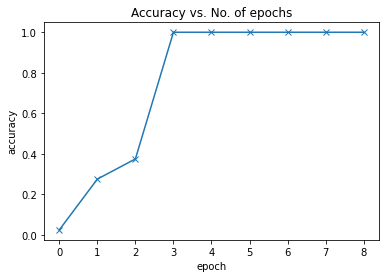

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

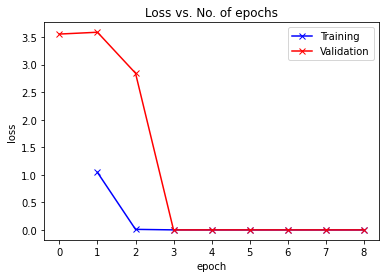

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

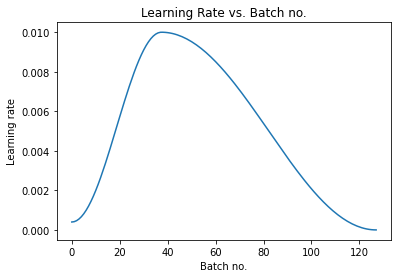

In [ ]:
plot_lrs(history)

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_data.classes[preds[0].item()]

In [ ]:
correct = []
for i in test_idx:
    img, lab = test_data[i]
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    correct.append(preds[0].item() == lab)
print(f"Accuracy [Test Data]: {sum(correct) / len(test_idx) * 100} %")

Accuracy [Test Data]: 100.0 %


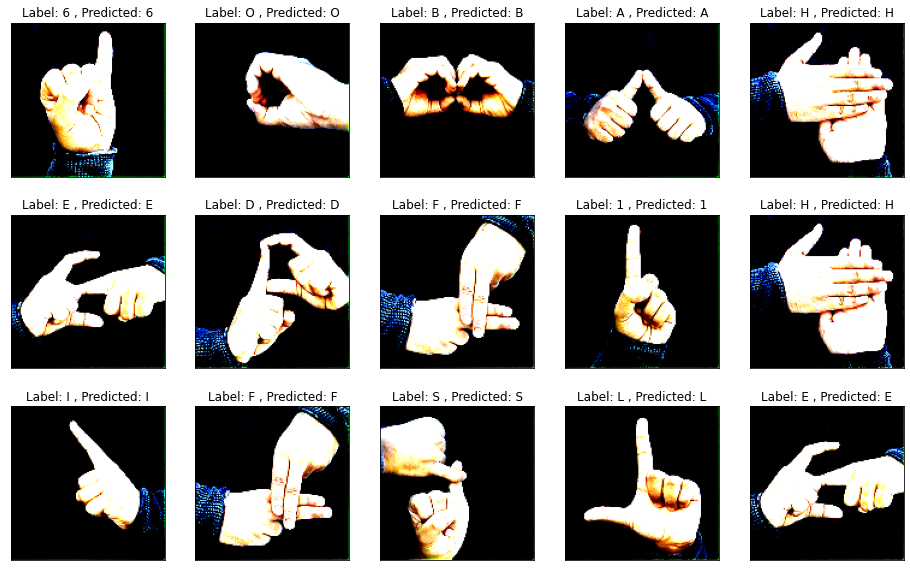

In [ ]:
n_rows, n_cols, i = 3, 5, 1
fig = plt.figure(figsize=(16,10))
for index in test_idx[:15]:
    img, label = test_data[index]
    ax = fig.add_subplot(n_rows, n_cols, i)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0).clamp(0,1))
    ax.set_title(f"Label: {test_data.classes[label]} , Predicted: {predict_image(img, model)}")
    i+=1

Label: 7 , Predicted: 7


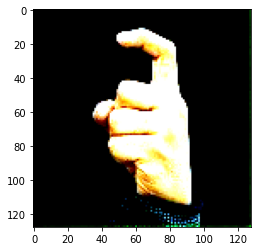

In [ ]:
img, label = valid_data[1024]
plt.imshow(img.permute(1, 2, 0))
print('Label:', valid_data.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
torch.save(model.state_dict(), 'ISN-2-custom-resnet.pth')
import joblib
filename = 'ISN-1-custom-resnet.sav'
joblib.dump(model, filename)

['ISN-1-custom-resnet.sav']